# English Project
# Author: Ian Karlo Torres dos Santos (ikts@cin.ufpe.br / ian.torres@ufpe.br)
#### This notebook is related to the final project of the English for Computing subject. It is based on what was done in the first mini project of the course containing some changes (which will be explained throughout the notebook) with the main objective of deploying the machine learning model on the Heroku platform.


#### First we start installing the fastai library and initalize it.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 197 kB 55.1 MB/s 
     |████████████████████████████████| 1.2 MB 41.8 MB/s 
     |████████████████████████████████| 60 kB 7.4 MB/s 
Mounted at /content/gdrive


#### Now we will download the training images of the model.
> In this project we will make one change, the third type will no longer be "Tony Tony Chopper" due some problems during the image downloads, so we will change it to "Vinsmoke Sanji", that is another One Piece character.

In [2]:
characters = ['Monkey D. Luffy', 'Roronoa Zoro', 'Vinsmoke Sanji']
path = Path('characters')

if not path.exists():
    path.mkdir()
    for character in characters:
        dest = (path/character)
        dest.mkdir(exist_ok=True)
        images_url = search_images_ddg(f'{character}', max_images=150)
        download_images(dest, urls=images_url)

#### Now we will see the downloaded and corrupted (if exists) files

In [3]:
fns = get_image_files(path)
failed = verify_images(fns)
print(f"files: {fns}")
print(f"corrupted: {failed}")

files: [Path('characters/Monkey D. Luffy/00000066.png'), Path('characters/Monkey D. Luffy/00000060.jpg'), Path('characters/Monkey D. Luffy/00000077.jpg'), Path('characters/Monkey D. Luffy/00000109.png'), Path('characters/Monkey D. Luffy/00000128.jpg'), Path('characters/Monkey D. Luffy/00000059.png'), Path('characters/Monkey D. Luffy/00000072.jpg'), Path('characters/Monkey D. Luffy/00000083.png'), Path('characters/Monkey D. Luffy/00000027.png'), Path('characters/Monkey D. Luffy/00000107.jpg'), Path('characters/Monkey D. Luffy/00000097.jpg'), Path('characters/Monkey D. Luffy/00000140.jpg'), Path('characters/Monkey D. Luffy/00000137.jpg'), Path('characters/Monkey D. Luffy/00000100.png'), Path('characters/Monkey D. Luffy/00000024.jpg'), Path('characters/Monkey D. Luffy/00000070.jpg'), Path('characters/Monkey D. Luffy/00000065.png'), Path('characters/Monkey D. Luffy/00000016.jpg'), Path('characters/Monkey D. Luffy/00000089.jpg'), Path('characters/Monkey D. Luffy/00000093.jpg'), Path('charac

> As we see that were some corrupted files, we need to remove them

In [4]:
failed.map(Path.unlink);

#### Now we will start the model traning as we learned in this chapter

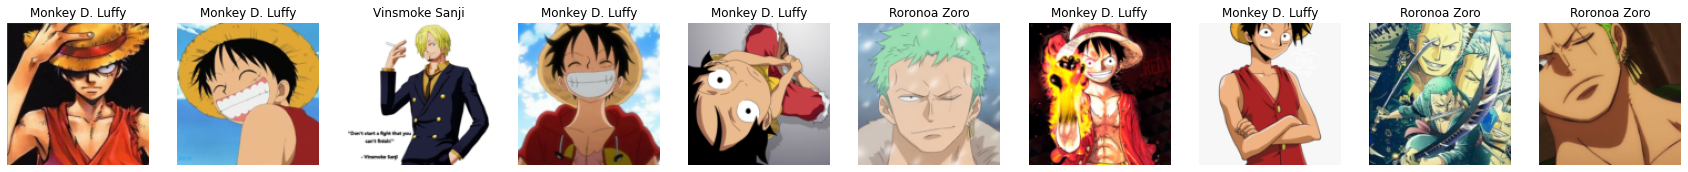

In [5]:
# The object name will be "pirates" just to reference the anime :)
pirates = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = pirates.dataloaders(path)
dls.valid.show_batch(max_n=10, nrows=1)

In [9]:
pirates = pirates.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pirates.dataloaders(path)

In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

> Print confusion matrix

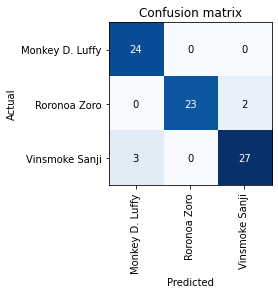

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

> Clean some wrong images

In [12]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [13]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

#### Now we will export our model

In [14]:
learn.export()

#### Then we can load our model and test it

In [18]:
model = load_learner('export.pkl')
# Lets test Sanji
sanji_pred = model.predict('sanji-test.png') #https://i.pinimg.com/originals/d5/b9/e7/d5b9e70f3400ae8d3b20549ba8d64cff.png used image url
# Lets test Luffy 
luffy_pred = model.predict('luffy-test.png')#https://gartic.com.br/imgs/mural/ti/tia_nami_swan/monkey-d-luffy-2.png used image url
# Lets test Zoro
zoro_pred = model.predict('zoro-test.png')#https://upload.wikimedia.org/wikipedia/pt/thumb/6/6e/Zor%C3%A3o.png/220px-Zor%C3%A3o.png used image url

print(f"Sanji prediction: {sanji_pred}")
print(f"Luffy prediction: {luffy_pred}")
print(f"Zoro prediction: {zoro_pred}")

Sanji prediction: ('Vinsmoke Sanji', TensorBase(2), TensorBase([1.3174e-04, 4.8973e-03, 9.9497e-01]))
Luffy prediction: ('Monkey D. Luffy', TensorBase(0), TensorBase([9.9992e-01, 3.5566e-05, 4.8190e-05]))
Zoro prediction: ('Roronoa Zoro', TensorBase(1), TensorBase([9.8251e-04, 9.9652e-01, 2.4934e-03]))


#### Now lets create the widgets to make a base to deploy our model

In [34]:
upload_button = widgets.FileUpload(
    
)

html = widgets.HTML(
    value='''
      <div style="display: flex; flex-direction: column; align-items: center;">
          <h2>One Piece Character Identifier</h2>
          <h4>Machine learning model that identifies some characters from the One Piece anime.</h4>
          <img style="margin-bottom: 10px;" src="https://sm.ign.com/ign_br/tv/o/one-piece-/one-piece-2_1xby.jpg" alt="OP"/>
      </div>
      
    ''',
    placeholder='Title',
    description=''
)

predict_button = widgets.Button(
    description='Predict',
    disabled=False,
    button_style='success',
    tooltip='Predict wich character is',
    icon='check'
)


predicted_value_img = None
predicted_value_name = None
predict_value_html = widgets.HTML(
    value=
    '<div style="display: flex; flex-direction: column; align-items: center;">'+
          f'<h4>{predicted_value_name}</h4>'+
          f'<img style="margin-bottom: 10px;" src="{predicted_value_img}" alt="OP"/>'+
    '</div>',
    placeholder='Title',
    description=''
)

def getPredictedValue(e):
  global predict_value_html
  global predicted_value_img
  global predicted_value_name


  predict_value_html.close()
  pred = model.predict(upload_button.data[-1])
  img_dict = {
      'Vinsmoke Sanji': 'https://i0.wp.com/mugiwarasoficial.com/wp-content/uploads/2021/10/Sanji-of-One-Piece.jpg?fit=960%2C500&ssl=1',
      'Roronoa Zoro': 'https://ovicio.com.br/wp-content/uploads/2021/07/20210712-one-piece-zoro-wano-postcover-1024x576.jpg',
      'Monkey D. Luffy': 'https://nerdhits.com.br/wp-content/uploads/2022/02/luffy-one-piece-1200x720.jpg'
  }
  predicted_value_img = img_dict[pred[0]]
  predicted_value_name = pred[0]

  predict_value_html = widgets.HTML(
    value=
    '<div style="display: flex; flex-direction: column; align-items: center;">'+
          f'<h2>Your character is {predicted_value_name}</h2>'+
          f'<img style="margin-bottom: 10px;" src="{predicted_value_img}" alt="OP"/>'+
    '</div>',
    placeholder='Title',
    description=''
  )
  display(predict_value_html)



predict_button.on_click(getPredictedValue)

display(html)
display(upload_button)
display(predict_button)


HTML(value='\n      <div style="display: flex; flex-direction: column; align-items: center;">\n          <h2>O…

FileUpload(value={}, description='Upload')

Button(button_style='success', description='Predict', icon='check', style=ButtonStyle(), tooltip='Predict wich…

HTML(value='<div style="display: flex; flex-direction: column; align-items: center;"><h2>Your character is Vin…

#### Now lets configure our notebook to deploy

In [ ]:
!pip install voila tornado~=5.1.0
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 516 kB 5.1 MB/s 
     |████████████████████████████████| 130 kB 60.1 MB/s 
     |████████████████████████████████| 130 kB 70.5 MB/s 
     |████████████████████████████████| 130 kB 70.8 MB/s 
     |████████████████████████████████| 130 kB 72.1 MB/s 
     |████████████████████████████████| 343 kB 52.7 MB/s 
     |████████████████████████████████| 341 kB 60.1 MB/s 
     |████████████████████████████████| 341 kB 56.7 MB/s 
     |████████████████████████████████| 341 kB 55.3 MB/s 
     |████████████████████████████████| 341 kB 55.5 MB/s 
     |████████████████████████████████| 340 kB 60.6 MB/s 
     |████████████████████████████████| 339 kB 60.8 MB/s 
     |████████████████████████████████| 339 kB 25.0 MB/s 
     |████████████████████████████████| 397 kB 63.5 MB/s 
     |████████████████████████████████| 395 kB 60.9 MB/s 
     |████████████████████████████████| 395 kB 48.9 MB/s 
     |████████████████████████████████| 395 kB 64.8 MB/s 
     |█████████